In [1]:
from sklearn.datasets import fetch_20newsgroups

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from sklearn.metrics import accuracy_score, f1_score

In [4]:
from sklearn.cross_validation import train_test_split

# Topic Modeling

(Great example from [Edwin Chen](http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/))

Suppose you have the following set of sentences:

* I like to eat broccoli and bananas.
* I ate a banana and spinach smoothie for breakfast.
* Chinchillas and kittens are cute.
* My sister adopted a kitten yesterday.
* Look at this cute hamster munching on a piece of broccoli.

What is latent Dirichlet allocation? It’s a way of automatically discovering topics that these sentences contain.  For example, given these sentences and asked for 2 topics, LDA might produce something like

* Sentences 1 and 2: 100% Topic A
* Sentences 3 and 4: 100% Topic B
* Sentence 5: 60% Topic A, 40% Topic B
* Topic A: 30% broccoli, 15% bananas, 10% breakfast, 10% munching, … (at which point, you could interpret topic A to be about food)
* Topic B: 20% chinchillas, 20% kittens, 20% cute, 15% hamster, … (at which point, you could interpret topic B to be about cute animals)

# Why do we want this?

Topic models:

* Help us visualize and interpret what is going on in the data. (Single words, or even n-grams, can be ambiguous.)
* Reduce dimensionality, making the problem easier for machine learning predictors.
* Reduce overfitting and make it easier to extend to new data.

In [5]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             categories=('rec.sport.hockey', 'soc.religion.christian',
                                         'rec.motorcycles', 'rec.sport.baseball', 'sci.crypt'),
                             remove=('headers', 'footers', 'quotes'))

In [6]:
docs, y = dataset['data'], dataset['target']

In [7]:
docs_train, docs_val, y_train, y_val = train_test_split(docs, y, test_size=0.25, random_state=0)

In [8]:
dataset.target_names

['rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'soc.religion.christian']

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
vect = CountVectorizer()

In [12]:
X_train = vect.fit_transform(docs_train)

In [13]:
X_train.shape

(2241, 27891)

That's a lot of words. Let's add a document-frequency threshold.

In [14]:
vect.set_params(min_df=5)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [15]:
X_train = vect.fit_transform(docs_train)

In [16]:
X_train.shape

(2241, 5955)

That's better.  Still, it's a bit unsatisfying that we just chose an arbitrary number. We'll get back to that later.

In [17]:
from sklearn.decomposition import LatentDirichletAllocation

In [18]:
topic_model = LatentDirichletAllocation(n_topics=15, max_iter=20, random_state=0)

In [19]:
%time topic_model.fit(X_train)

CPU times: user 30.6 s, sys: 42.8 s, total: 1min 13s
Wall time: 26.3 s


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=20, mean_change_tol=0.001,
             n_jobs=1, n_topics=15, perp_tol=0.1, random_state=0,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [20]:
def topic_names(model, feature_names, n_top_words=3):
    return [
        " ".join([feature_names[i]
                  for i in topic.argsort()[:-n_top_words - 1:-1]
                 ])
        for topic in model.components_]

In [21]:
topic_names(topic_model, vect.get_feature_names(), n_top_words=3)

['sox morris red',
 'go let phillies',
 'lankford gilkey jordan',
 'flyers puck at',
 '10 25 11',
 'and the of',
 'the he in',
 'hidden phrases total',
 'the to and',
 'com that is',
 'perry cylinder pitt',
 'the to and',
 'bo virginia tm',
 'hockey vs new',
 'the of to']

# What went well?

* We got a "hockey" topic!

... but the rest is garbage :(


# What went wrong?

* lots of uninformative words
* did we train enough?
* lots of numbers?

In [22]:
X_train_topics = topic_model.transform(X_train) 

In [23]:
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs').fit(X_train_topics, y_train)
X_val = vect.transform(docs_val)
X_val_topics = topic_model.transform(X_val)
y_pred = lr.predict(X_val_topics)

In [24]:
print("Accuracy: {:.4f}".format(accuracy_score(y_pred, y_val)))
print("F1 score: {:.4f}".format(f1_score(y_pred, y_val, average='macro')))

Accuracy: 0.6979
F1 score: 0.6976


# Fix 1. Dealing with numeric tokens

## (Or other custom tokenization needs)


In [25]:
default_tokenizer = vect.build_tokenizer()
default_tokenizer("I got 99 problems __")

['got', '99', 'problems', '__']

## Aside: *Wait, what*? *Why*?

In [26]:
print(vect.token_pattern)

(?u)\b\w\w+\b


For some applications (that you *miiiight* tackle really soon), some one-letter words are important!

* "I" vs "we"
* "a" (and "an") vs "the"

But do you think these would be useful in comparing baseball to hockey?

## Customizing the tokenizer

In [27]:
import re

default_tokenizer = re.compile(r"(?u)\b\w\w+\b")

def number_aware_tokenizer(doc):
    # Start off with the default tokenizer
    toks = default_tokenizer.findall(doc)
    # replace tokens that start with numbers with a custom marker
    toks = [
        "#NBR" if t[0].isdigit() else t  # substitute numeric-starting tokens
        for t in toks
        if t.isalnum()  # drop non-alphanumeric tokens
    ]
    return toks

In [28]:
number_aware_tokenizer("I got 99 problems __")

['got', '#NBR', 'problems']

## Muuuch better!

# Fix 2. Choosing frequency thresholds
(Let's look at what our documents are made of)

In [29]:
print("What are the most common words?")

word_counts = X_train.sum(axis=0)
word_counts = word_counts.A.ravel().astype(np.double)  # because X_train is a matrix, not an array
word_counts /= word_counts.sum()

# pair up words with their counts
paired = zip(word_counts, vect.get_feature_names())

# sort them in decreasing order
paired = sorted(paired, reverse=True)
for freq, word in paired[:10]:
    print(word, freq)

print()
print("Least common:")

for freq, word in paired[:-10:-1]:
    print(word, freq)

What are the most common words?
the 0.0607413120749
to 0.0295197976278
of 0.0256390202858
and 0.0230122814872
in 0.0172976413288
is 0.0171870701884
that 0.0162027173532
it 0.0123435148678
for 0.0101563637737
be 0.00863533637898

Least common:
16th 1.34842854138e-05
1919 1.34842854138e-05
272 1.34842854138e-05
2758 1.34842854138e-05
313 1.34842854138e-05
340 1.34842854138e-05
3511 1.34842854138e-05
374 1.34842854138e-05
403 1.34842854138e-05


 * We have a lot of very frequent words (stopwords)

 * We have a lot of numbers (or number-like: *16th*) low-frequency tokens.

# Fix for frequent words:

We have already seen the `min_df` heuristic to avoid very rare words.
There is a similar `max_df` heuristic to avoid very common words. But what should we set it to?

In [30]:
# df = number of documents each word appears in.

df = (X_train > 0).sum(axis=0)
df = df.A.ravel().astype(np.double)

df /= X_train.shape[0]

In [31]:
print("Words with highest df")

# pair up words with their DF
paired = zip(df, vect.get_feature_names())

# sort them in decreasing order
paired = sorted(paired, reverse=True)
for freq, word in paired[:300]:
    print(word, freq)


Words with highest df
the 0.858099062918
to 0.744756804998
and 0.69567157519
of 0.688978134761
in 0.651494868362
that 0.621597501116
is 0.611780455154
it 0.585899152164
for 0.558232931727
this 0.493975903614
on 0.476126729139
be 0.473895582329
have 0.456046407854
you 0.439535921464
but 0.43641231593
not 0.428380187416
with 0.424810352521
if 0.411869701026
are 0.401606425703
as 0.383757251227
or 0.367246764837
they 0.360107095047
was 0.357875948237
at 0.346273984828
can 0.336010709505
one 0.319053993753
from 0.311914323963
would 0.302543507363
all 0.298081213744
by 0.296296296296
about 0.289602855868
there 0.285140562249
what 0.282016956716
so 0.281570727354
an 0.281570727354
has 0.273092369478
will 0.27130745203
he 0.270861222668
do 0.270861222668
my 0.267291387773
who 0.260597947345
just 0.25479696564
no 0.248995983936
me 0.245426149041
out 0.244979919679
like 0.244533690317
any 0.241856314145
we 0.237394020527
some 0.236501561803
don 0.23114680946
more 0.222222222222
only 0.213743864

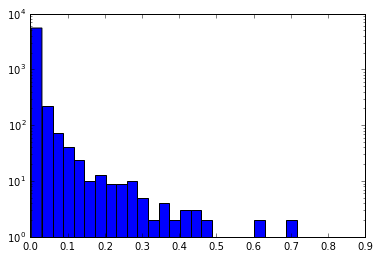

In [32]:
plt.hist(df, log=True, bins=30)
plt.show()

No real rule, but you can use your intuition:

* After what threshold do you start seeing *useful* words?
* Does the histogram have an "elbow"?

0.11 looks like a good threshold on our data. *(Would you have guessed this is the range to search in?)*

In [33]:
vect = CountVectorizer(min_df=5,
                       max_df=0.11,
                       tokenizer=number_aware_tokenizer)

X_train = vect.fit_transform(docs_train)

In [34]:
X_train_topics = topic_model.fit_transform(X_train)

In [35]:
topic_names(topic_model, vect.get_feature_names(), n_top_words=5)

['dave jewish hall pitcher smith',
 'edu mail com list dod',
 'her she marriage mary bear',
 'maine prince passion saint cub',
 'homosexuality drivers thanks homosexual change',
 'church catholic pope canon schism',
 'game games better runs won',
 'key encryption chip security privacy',
 'players team player fan baseball',
 'bike off got down ve',
 'team hockey play game season',
 'jesus dead resurrection tomb body',
 'god our jesus believe us',
 'law government use question must',
 'gm john moncton murray springfield']

In [36]:
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs').fit(X_train_topics, y_train)
X_val = vect.transform(docs_val)
X_val_topics = topic_model.transform(X_val)
y_pred = lr.predict(X_val_topics)

In [37]:
print("Accuracy: ", accuracy_score(y_pred, y_val))
print("F1 score: ", f1_score(y_pred, y_val, average='macro'))

Accuracy:  0.81550802139
F1 score:  0.820034196276


# Interpreting the model

In [38]:
topic_labels = topic_names(topic_model, vect.get_feature_names(), n_top_words=5)

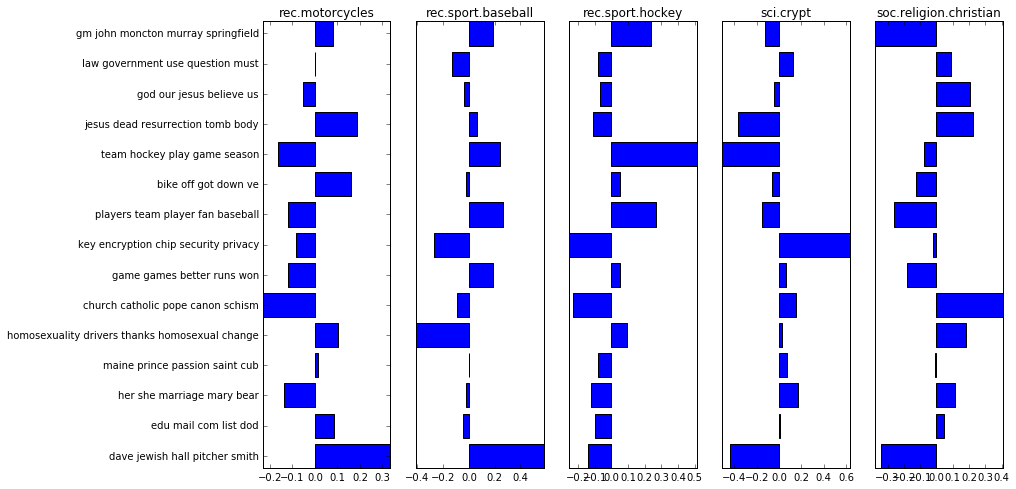

In [39]:
coef = lr.coef_
n_targets, n_topics = coef.shape
plt.figure(figsize=(16, 8))
for k in range(coef.shape[0]):
    plt.subplot(1, n_targets + 1, k + 1)
    plt.title(dataset.target_names[k])
    plt.barh(np.arange(1, n_topics + 1), coef[k], align='center')
    if k == 0:
        plt.yticks(np.arange(1, n_topics + 1),
                   topic_labels)
    else:
        plt.yticks(())
    plt.axis("tight")

 Is this the best we can do?